In [3]:
pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 36.9 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


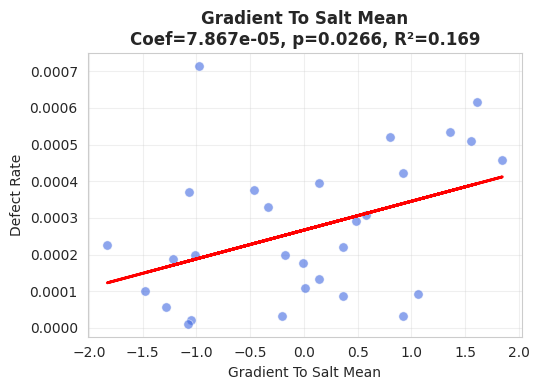

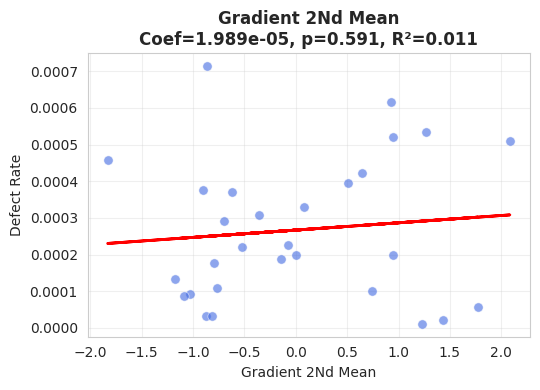

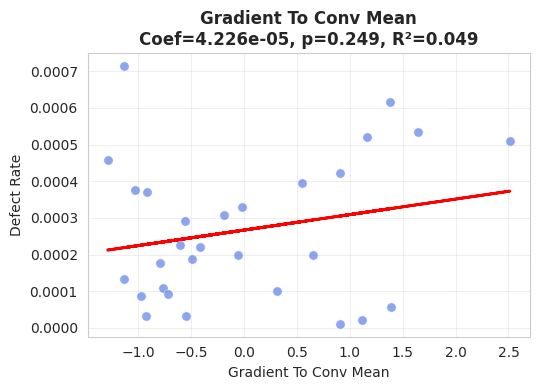

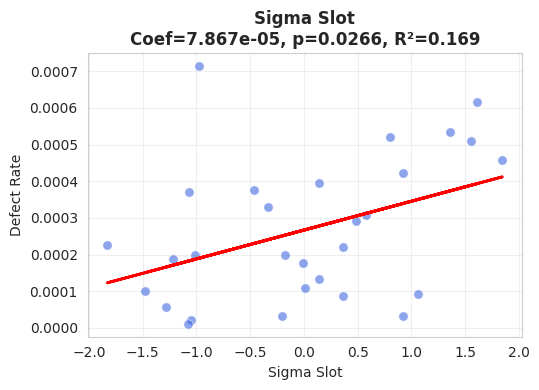

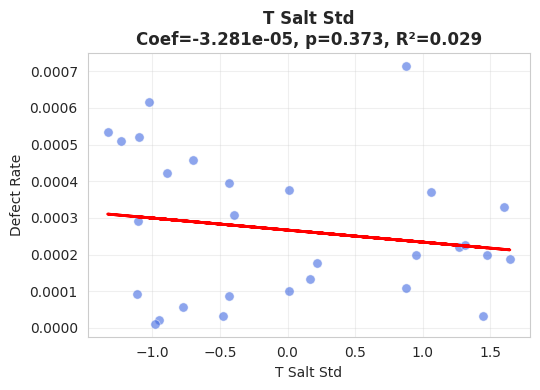

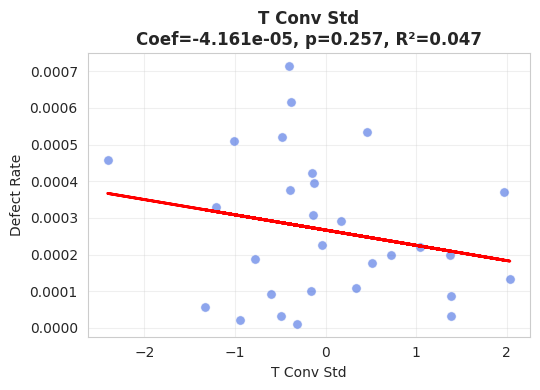

In [1]:
# ============================================================
# 단순 선형회귀 (각 피처별 개별 시각화)
# ============================================================

import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 불러오기
df = pd.read_csv("processed_regression_data.csv")

# 주요 피처 목록
features = [
    "gradient_to_salt_mean",
    "gradient_2nd_mean",
    'gradient_to_conv_mean',
    "sigma_slot",
    "T_salt_std",
    "T_conv_std"
]
target = "defect_rate"
results = []

def prettify(name: str) -> str:
    return name.replace("_", " ").title()

# Style setting
sns.set_style("whitegrid")

for feature in features:
    if feature not in df.columns:
        print(f"{feature} not found, skip")
        continue

    # OLS
    X = sm.add_constant(df[feature])
    y = df[target]
    model = sm.OLS(y, X, missing='drop').fit()

    # results
    if len(model.params) > 1:
        coef = model.params.iloc[1]
        pval = model.pvalues.iloc[1]
    else:
        coef, pval = 0, 1
    r2 = model.rsquared
    results.append({
        "Feature": feature,
        "Coef": coef,
        "P_value": pval,
        "R²": r2
    })

    pretty_name = prettify(feature)
    title_text = f"{pretty_name}\nCoef={coef:.3e}, p={pval:.3g}, R²={r2:.3f}"

    # Plot
    plt.figure(figsize=(5.5, 4))
    sns.scatterplot(x=df[feature], y=y, color='royalblue', alpha=0.6, s=45)
    plt.plot(df[feature], model.predict(X), color='red', linewidth=2)
    plt.title(title_text, fontsize=12, fontweight='bold')
    plt.xlabel(pretty_name)
    plt.ylabel("Defect Rate")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    
    # save image
    fname = f"linear_{feature}.png"
    plt.savefig(fname, dpi=150)
# ============================================================
# 결과 요약 저장
# ============================================================
summary_df = pd.DataFrame(results).sort_values("R²", ascending=False)
summary_df.to_csv("simple_linear_results.csv", index=False, encoding="utf-8-sig")


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ======================================
# Matplotlib / Seaborn setup
# ======================================
plt.rcParams['font.family'] = 'Times New Roman' 
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 11
sns.set_style("whitegrid")

# ======================================
# Load simple linear regression summary
# ======================================
df = pd.read_csv("simple_linear_results.csv")

# Convert p-values to -log10 scale for better visualization
df["logP"] = -np.log10(df["P_value"].replace(0, 1e-12))

# ======================================
# R² Comparison Barplot
# ======================================
plt.figure(figsize=(7, 4))
sns.barplot(data=df, x="R²", y="Feature", hue="Feature", palette="crest", legend=False)
plt.title("Simple Linear Regression — R² Comparison", fontsize=13, fontweight='bold')
plt.xlabel("R² (Explained Variance)")
plt.ylabel("Feature")
plt.xlim(0, df["R²"].max() * 1.3)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("linear_R2_comparison.png", dpi=300, bbox_inches="tight")
plt.close()

# ======================================
# Coefficient Comparison
# ======================================
plt.figure(figsize=(7, 4))
sns.barplot(data=df, x="Coef", y="Feature", hue="Feature",
            palette="coolwarm", dodge=False, legend=False)
plt.title("Simple Linear Regression — Coefficient Comparison", fontsize=13, fontweight='bold')
plt.xlabel("Regression Coefficient")
plt.ylabel("Feature")
plt.axvline(0, color='black', linestyle='--', alpha=0.7)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("linear_coef_comparison.png", dpi=300, bbox_inches="tight")
plt.close()

# ======================================
# p-value Heatmap
# ======================================
plt.figure(figsize=(5, 3))
pivot = df[["Feature", "logP"]].set_index("Feature").sort_values("logP", ascending=True)
sns.heatmap(pivot, annot=True, cmap="YlOrRd",
            cbar_kws={'label': '-log10(p-value)'}, fmt=".2f")
plt.title("Statistical Significance (−log10 p-value)", fontsize=13, fontweight='bold')
plt.xlabel("")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("linear_pvalue_heatmap.png", dpi=300, bbox_inches="tight")
plt.close()